In [26]:
BATCH_SIZE = 32
IMG_SIZE = (64, 128)

data_dir = 'glasses_gan/crops/'

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random

os.environ["CUDA_VISIBLE_DEVICES"]="0"

Found 4920 files belonging to 2 classes.
Using 3444 files for training.
Found 4920 files belonging to 2 classes.
Using 1476 files for validation.
Number of training batches: 108
Number of validation batches: 38
Number of test batches: 9
['glasses', 'no_glasses']
-1


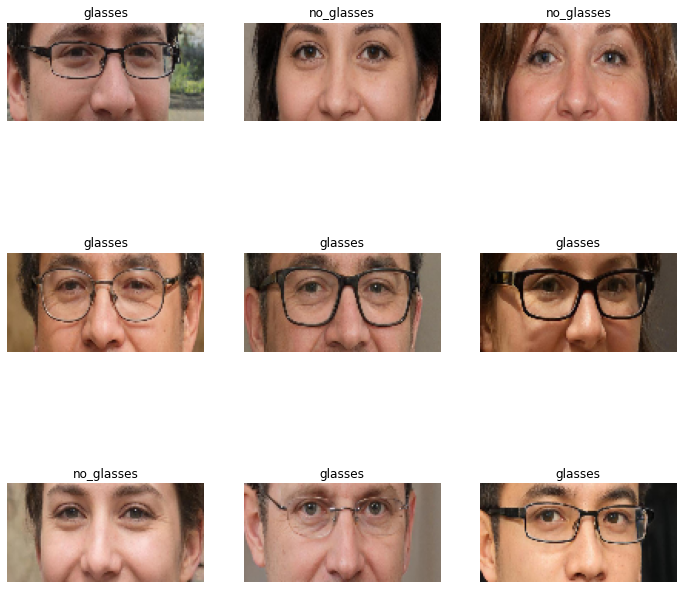

In [27]:
import tensorflow as tf

tf.random.set_seed(123456)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, Adam


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

class_names = train_dataset.class_names
print(class_names)


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
print(AUTOTUNE)


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])



plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [30]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE, alpha=1.0, minimalistic=True, include_top=False,
    weights='imagenet', input_tensor=None, classes=1000, pooling=None,
    dropout_rate=0.2, classifier_activation='softmax'
)

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

(32, 2, 4, 1024)


In [34]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = Dense(1, activation=None)(x)

model = Model(inputs=inputs, outputs=predictions)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

len(model.trainable_variables)

2

In [35]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

model_fit = model.fit(train_dataset,
                      epochs=initial_epochs,
                      validation_data=validation_dataset)

38/38 [==============================] - 14s 216ms/step - loss: 0.4806 - accuracy: 0.6135
initial loss: 0.48
initial accuracy: 0.61
Epoch 1/10
108/108 [==============================] - 40s 326ms/step - loss: 0.3540 - accuracy: 0.8380 - val_loss: 0.2076 - val_accuracy: 0.9596
Epoch 2/10
108/108 [==============================] - 43s 388ms/step - loss: 0.2188 - accuracy: 0.9158 - val_loss: 0.1422 - val_accuracy: 0.9773
Epoch 3/10
108/108 [==============================] - 37s 334ms/step - loss: 0.1577 - accuracy: 0.9486 - val_loss: 0.1101 - val_accuracy: 0.9781
Epoch 4/10
108/108 [==============================] - 39s 346ms/step - loss: 0.1274 - accuracy: 0.9602 - val_loss: 0.0947 - val_accuracy: 0.9790
Epoch 5/10
108/108 [==============================] - 40s 353ms/step - loss: 0.1003 - accuracy: 0.9710 - val_loss: 0.0867 - val_accuracy: 0.9790
Epoch 6/10
108/108 [==============================] - 39s 346ms/step - loss: 0.0870 - accuracy: 0.9733 - val_loss: 0.0738 - val_accuracy: 0.982

In [36]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

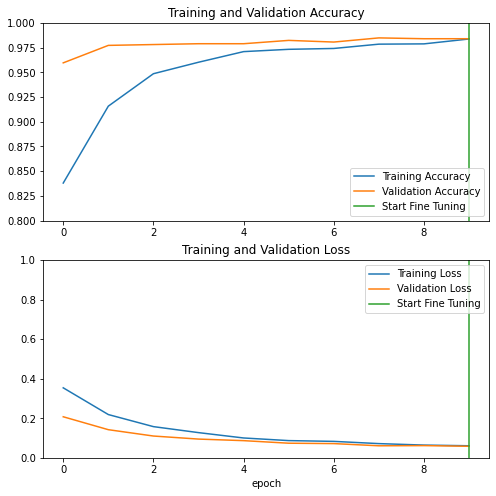

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

108/108 [==============================] - 24s 204ms/step - loss: 0.0428 - accuracy: 0.9890
Test accuracy : 0.9930555820465088
Train accuracy : 0.9889663457870483


In [39]:
base_model.trainable = True

In [40]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 47
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  105


In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [42]:
len(model.trainable_variables)

61

In [43]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                           epochs=total_epochs,
                           initial_epoch=model_fit.epoch[-1],
                           validation_data=validation_dataset)

Epoch 10/15
108/108 [==============================] - 63s 418ms/step - loss: 0.0366 - accuracy: 0.9899 - val_loss: 0.0274 - val_accuracy: 0.9899
Epoch 11/15
108/108 [==============================] - 41s 362ms/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.0232 - val_accuracy: 0.9924
Epoch 12/15
108/108 [==============================] - 45s 403ms/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.0170 - val_accuracy: 0.9933
Epoch 13/15
108/108 [==============================] - 42s 379ms/step - loss: 0.0082 - accuracy: 0.9972 - val_loss: 0.0111 - val_accuracy: 0.9958
Epoch 14/15
108/108 [==============================] - 45s 406ms/step - loss: 0.0098 - accuracy: 0.9960 - val_loss: 0.0106 - val_accuracy: 0.9975
Epoch 15/15
108/108 [==============================] - 43s 388ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0092 - val_accuracy: 0.9958


In [44]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

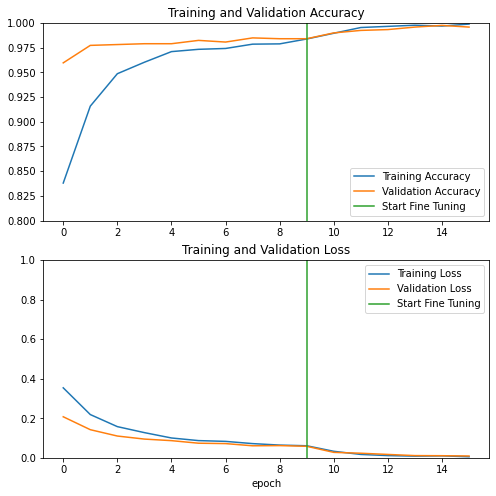

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Raw Predictions:
 [ 15.9705    -17.345596   -8.594919   10.044754  -12.795396  -11.509245
 -12.35416   -11.735829    7.311027   -9.792248   -9.638846  -14.9710045
 -14.996416   12.375222  -12.374597   -9.526347   10.55449   -13.812824
 -14.78512   -11.47493   -15.181902    8.997817  -11.538988  -14.8199005
   5.674352  -12.067305   -9.496116    5.331257    6.41844   -13.358282
  10.412234    6.3880754]
Raw Predictions 2:
 tf.Tensor(
[1.0000000e+00 2.9302402e-08 1.8504262e-04 9.9995655e-01 2.7735127e-06
 1.0036873e-05 4.3117775e-06 8.0019172e-06 9.9933243e-01 5.5883145e-05
 6.5148168e-05 3.1490197e-07 3.0700062e-07 9.9999583e-01 4.2245551e-06
 7.2905452e-05 9.9997389e-01 1.0026899e-06 3.7923110e-07 1.0387267e-05
 2.5502558e-07 9.9987638e-01 9.7427401e-06 3.6626801e-07 9.9657881e-01
 5.7442876e-06 7.5143143e-05 9.9518526e-01 9.9837148e-01 1.5796898e-06
 9.9996996e-01 9.9832135e-01], shape=(32,), dtype=float32)
Predictions:
 [1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1

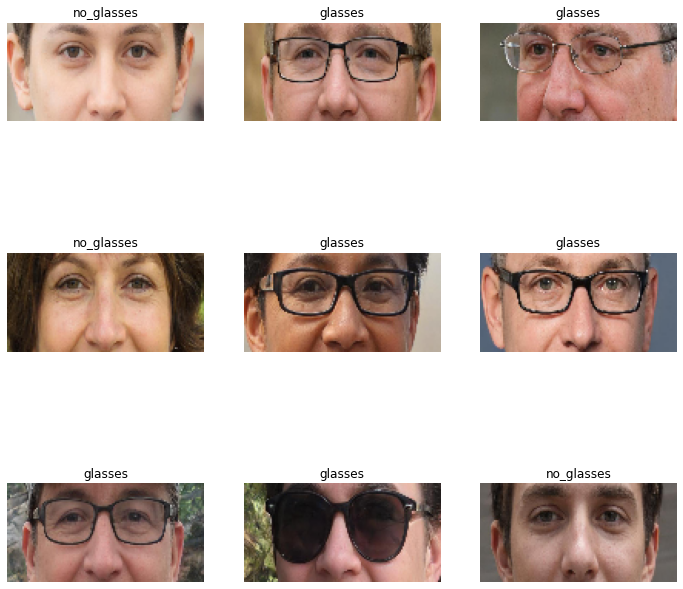

In [46]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

print('Raw Predictions:\n', predictions)

predictions = tf.nn.sigmoid(predictions)

print('Raw Predictions 2:\n', predictions)

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [47]:
model.save('weights/model_keras.h5')

# from tensorflow import keras
# model2 = keras.models.load_model('weights/model_keras.h5')

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

import pathlib
tflite_models_dir = pathlib.Path("weights")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"fp16_model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/jx/9nb25k_n27l0gk2vkjs8mx6c0000gn/T/tmp_43j265v/assets


2071744

Raw Predictions:
 [ 15.745755  -17.313707   -8.6110325   9.964764  -12.821229  -11.482265
 -12.305038  -11.738846    7.3408604  -9.917433   -9.676855  -14.834915
 -15.058193   12.344189  -12.360716   -9.501593   10.5528555 -13.725912
 -14.820536  -11.508424  -15.224806    8.903989  -11.667296  -14.763056
   5.572074  -12.118799   -9.463667    5.2439423   6.5054436 -13.392002
  10.441483    6.5697665]
Raw Predictions 2:
 tf.Tensor(
[1.0000000e+00 3.0251886e-08 1.8206239e-04 9.9995291e-01 2.7027818e-06
 1.0311349e-05 4.5288684e-06 7.9778165e-06 9.9935198e-01 4.9307579e-05
 6.2718434e-05 3.6080971e-07 2.8860893e-07 9.9999559e-01 4.2836041e-06
 7.4732714e-05 9.9997389e-01 1.0937350e-06 3.6603547e-07 1.0045118e-05
 2.4431540e-07 9.9986422e-01 8.5695410e-06 3.8769156e-07 9.9621183e-01
 5.4559750e-06 7.7621437e-05 9.9474835e-01 9.9850702e-01 1.5273107e-06
 9.9997079e-01 9.9859989e-01], shape=(32,), dtype=float32)
Predictions:
 [1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1]


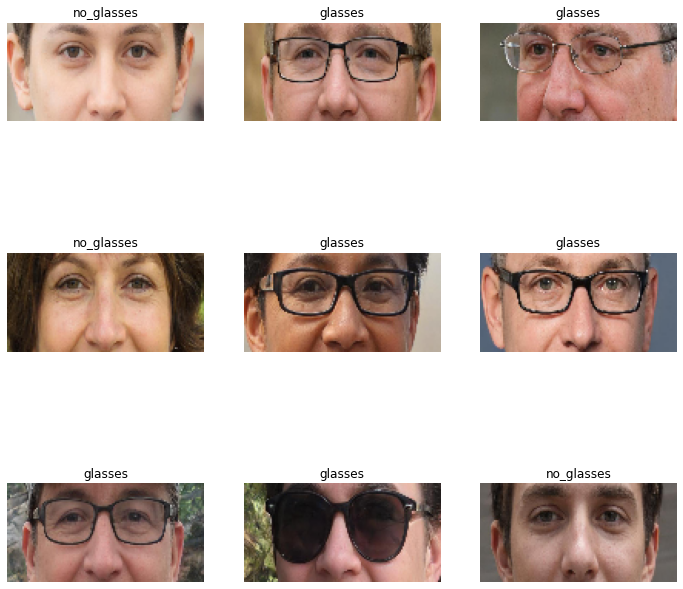

In [49]:
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()


def predict_on_images(images, model_path):
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    predictions = []
    
    for image in image_batch.astype(np.float32):
        interpreter.set_tensor(input_index, np.expand_dims(image, axis=0))
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_index).flatten()[0])
        
    return np.array(predictions)

predictions = predict_on_images(image_batch, tflite_model_file)

print('Raw Predictions:\n', predictions)

predictions = tf.nn.sigmoid(predictions)

print('Raw Predictions 2:\n', predictions)

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [52]:
real_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'example_data_glasses_crops',
    shuffle=False,
    seed=123456,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 40 files belonging to 2 classes.


Raw Predictions:
 [ -9.014357   -6.9568458 -10.284415   -9.015904   -8.172762   -8.979059
  -9.324967   -7.3441224 -11.992123   -9.726135   -3.2414773  -9.600646
  -6.020584  -11.498035  -10.124037  -10.8468895 -11.718165  -11.345715
  -9.043887   -6.5922146   9.989079    8.232852    6.948914   11.094036
   6.663355    2.3272305  14.437091    1.5036368   9.0554695  11.349257
  13.559935    3.1539838]
Raw Predictions 2:
 tf.Tensor(
[1.21650715e-04 9.51170921e-04 3.41613631e-05 1.21462566e-04
 2.82168388e-04 1.26063824e-04 8.91698655e-05 6.45965338e-04
 6.19280354e-06 5.97025828e-05 3.76343131e-02 6.76849959e-05
 2.42233276e-03 1.01500145e-05 4.01039069e-05 1.94650602e-05
 8.14451869e-06 1.18200351e-05 1.18110831e-04 1.36908889e-03
 9.99954104e-01 9.99734282e-01 9.99041259e-01 9.99984741e-01
 9.98724818e-01 9.11107302e-01 9.99999523e-01 8.18116248e-01
 9.99883175e-01 9.99988198e-01 9.99998689e-01 9.59065378e-01], shape=(32,), dtype=float32)
Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

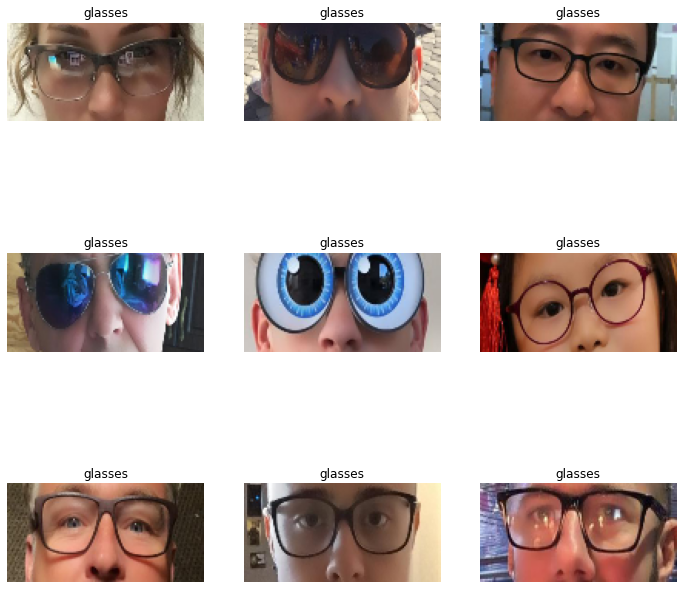

In [53]:
image_batch, label_batch = real_test_dataset.as_numpy_iterator().next()


def predict_on_images(images, model_path):
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    predictions = []
    
    for image in image_batch.astype(np.float32):
        interpreter.set_tensor(input_index, np.expand_dims(image, axis=0))
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_index).flatten()[0])
        
    return np.array(predictions)

predictions = predict_on_images(image_batch, tflite_model_file)

print('Raw Predictions:\n', predictions)

predictions = tf.nn.sigmoid(predictions)

print('Raw Predictions 2:\n', predictions)

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")